In [1]:
!pip install geopandas

In [0]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

Are we filtering the right rides?
Let's check with the old format (2016-01 to 2016-06), since the new format has only taxi zones:

In [3]:
!mkdir /tmp/taxi/
!wget -P '/tmp/taxi/' -nc 'https://raw.githubusercontent.com/ischender/ML_workshop/master/data/taxi/yellow_tripdata_2016-06.csv' 'https://raw.githubusercontent.com/ischender/ML_workshop/master/data/taxi/yellow_tripdata_2016-06-filtered.csv' 
!ls /tmp/taxi/

mkdir: cannot create directory ‘/tmp/taxi/’: File exists
File ‘/tmp/taxi/yellow_tripdata_2016-06.csv’ already there; not retrieving.

File ‘/tmp/taxi/yellow_tripdata_2016-06-filtered.csv’ already there; not retrieving.

yellow_tripdata_2016-06.csv  yellow_tripdata_2016-06-filtered.csv


In [4]:
BASEDIR = '/tmp/taxi/'
original_file = BASEDIR + 'yellow_tripdata_2016-06.csv'
filtered_file = BASEDIR + 'yellow_tripdata_2016-06-filtered.csv'
filtered_data = pd.read_csv(filtered_file)
filtered_data.shape

(999, 20)

In [5]:
# we just want SOME trips, 10000 is OK
original_data = next(pd.read_csv(original_file, chunksize=10000))
original_data.shape

(999, 19)

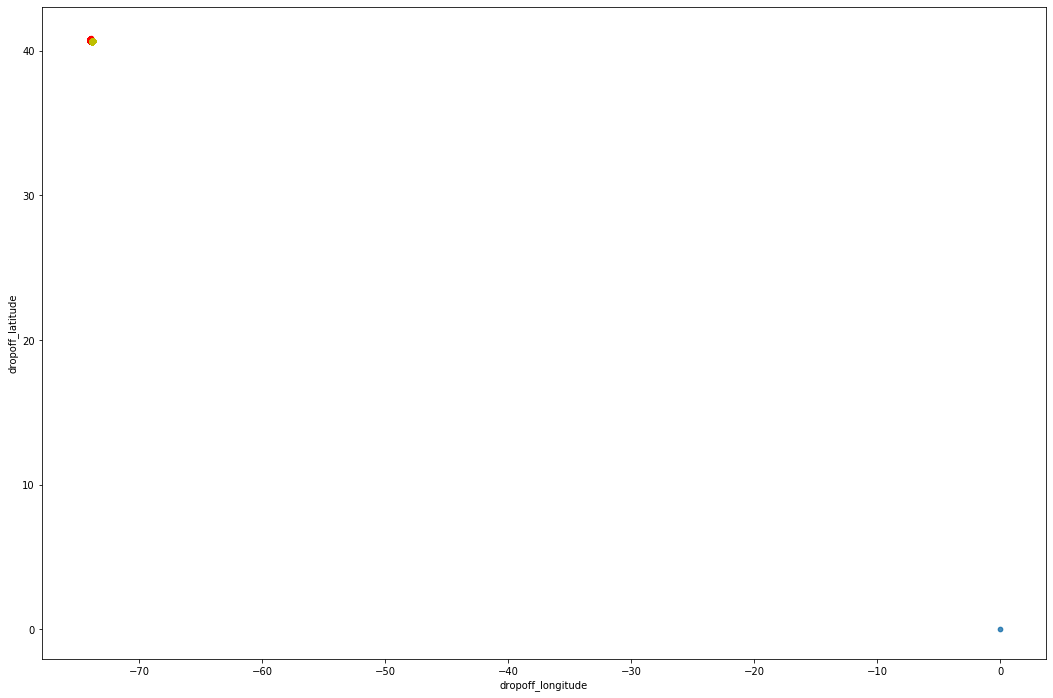

In [6]:
fig, ax = plt.subplots(figsize = (18,12))
# taxi_zones.plot(color='grey', ax=ax)
# all_trips.plot(kind="scatter", x="pickup_longitude", y="pickup_latitude", alpha=0.1, ax=ax)
original_data.plot.scatter(x="pickup_longitude", y="pickup_latitude", ax=ax, alpha=0.1)
filtered_data.plot(kind="scatter", x="pickup_longitude", y="pickup_latitude", ax=ax, c='r')
filtered_data.plot(kind="scatter", x="dropoff_longitude", y="dropoff_latitude", ax=ax, c='y')

apparently, some trips are coded very strangely...

In [7]:
for val in ['pickup_longitude','pickup_latitude', 'dropoff_longitude',	'dropoff_latitude']:
    print(val, original_data[val].max(), original_data[val].min())

pickup_longitude 0.0 -74.01717376708984
pickup_latitude 40.82366180419922 0.0
dropoff_longitude 0.0 -74.32269287109375
dropoff_latitude 40.88793182373047 0.0


I am pretty sure the trips from lat 0 lon 0 are a [miscoding], (https://www.google.com/maps/place/0°00'00.0"N+0°00'00.0"E/@0,-16.5706169,4z/data=!4m2!3m1!1s0x0:0x0), unless NYC taxis are very special indeed...


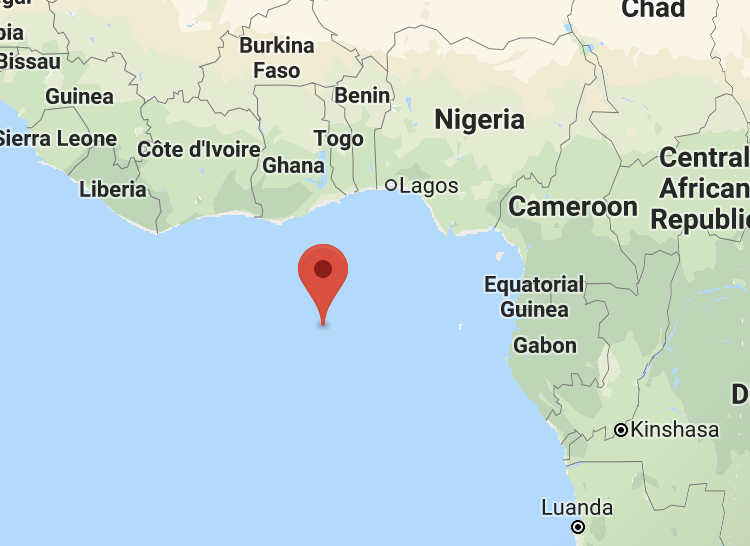

In [8]:
original_data[original_data['pickup_latitude'] == 0.0].head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
99,1,2016-06-09 21:13:24,2016-06-09 21:30:08,1,1.80,0.0,0.0,1,N,0.0,0.0,2,11.5,0.5,0.5,0.00,0.0,0.3,12.80
129,2,2016-06-09 21:06:00,2016-06-09 21:12:55,2,1.17,0.0,0.0,1,N,0.0,0.0,1,6.5,0.5,0.5,1.95,0.0,0.3,9.75
177,1,2016-06-09 21:06:44,2016-06-09 21:14:07,1,1.40,0.0,0.0,1,N,0.0,0.0,2,7.5,0.5,0.5,0.00,0.0,0.3,8.80
231,2,2016-06-09 21:13:25,2016-06-09 21:18:56,1,1.35,0.0,0.0,1,N,0.0,0.0,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36
317,1,2016-06-09 21:06:48,2016-06-09 21:16:19,1,1.00,0.0,0.0,1,N,0.0,0.0,1,8.0,0.5,0.5,1.86,0.0,0.3,11.16


In [9]:
# some cleanup
cols_lat = ['pickup_latitude', 'dropoff_latitude']
cols_lon = ['pickup_longitude', 'dropoff_longitude']
def remove_coordinate_outliers(some_trips):
    for col in cols_lat:
        some_trips = some_trips[some_trips[col] > 38]
        some_trips = some_trips[some_trips[col] < 42]
    for col in cols_lon:
        some_trips = some_trips[some_trips[col] > -76]
        some_trips = some_trips[some_trips[col] < -68]
    return some_trips

original_data = remove_coordinate_outliers(original_data)

for val in ['pickup_longitude','pickup_latitude', 'dropoff_longitude',	'dropoff_latitude']:
    print(val, original_data[val].max(), original_data[val].min())

# much better

pickup_longitude -73.78192138671875 -74.01717376708984
pickup_latitude 40.82366180419922 40.643531799316406
dropoff_longitude -73.76285552978516 -74.18575286865234
dropoff_latitude 40.88793182373047 40.58972549438477


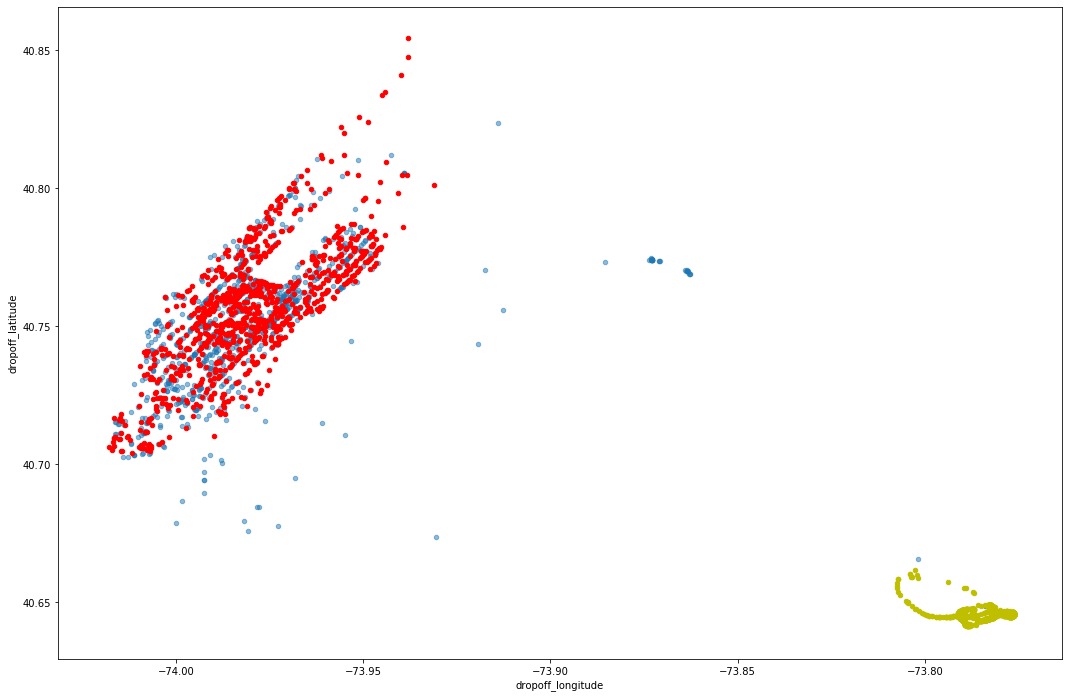

In [10]:
fig, ax = plt.subplots(figsize = (18,12))
original_data.plot.scatter(x="pickup_longitude", y="pickup_latitude", ax=ax, alpha=0.5)
filtered_data.plot(kind="scatter", x="pickup_longitude", y="pickup_latitude", ax=ax, c='r')
filtered_data.plot(kind="scatter", x="dropoff_longitude", y="dropoff_latitude", ax=ax, c='y')

it looks like most "pick up" trips are around a shape that I recognize as Manhattan, and the drop off around... well, JFK?
Let's overlay a map

In [11]:
# geopandas has NYC Boroughs as a dataset
nybb_path = gpd.datasets.get_path('nybb')
boros = gpd.read_file(nybb_path)
boros

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,5,Staten Island,330470.010332,1.623820e+09,"MULTIPOLYGON (((970217.022 145643.332, 970227...."
1,4,Queens,896344.047763,3.045213e+09,"MULTIPOLYGON (((1029606.077 156073.814, 102957..."
2,3,Brooklyn,741080.523166,1.937479e+09,"MULTIPOLYGON (((1021176.479 151374.797, 102100..."
3,1,Manhattan,359299.096471,6.364715e+08,"MULTIPOLYGON (((981219.056 188655.316, 980940...."
4,2,Bronx,464392.991824,1.186925e+09,"MULTIPOLYGON (((1012821.806 229228.265, 101278..."


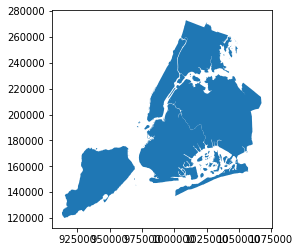

In [12]:
# but the coordinates look very weird
boros.plot()

In [13]:
boros.crs

{'init': 'epsg:2263'}

In [0]:
# epsg 2263 is apparently LIDAR data... who knows why that's the formnat they choose

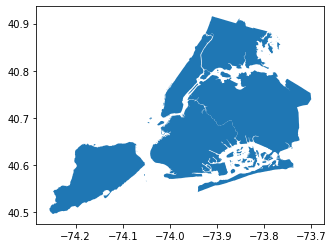

In [15]:
boros = boros.to_crs(epsg=4326) # normal lat/long
boros.plot()

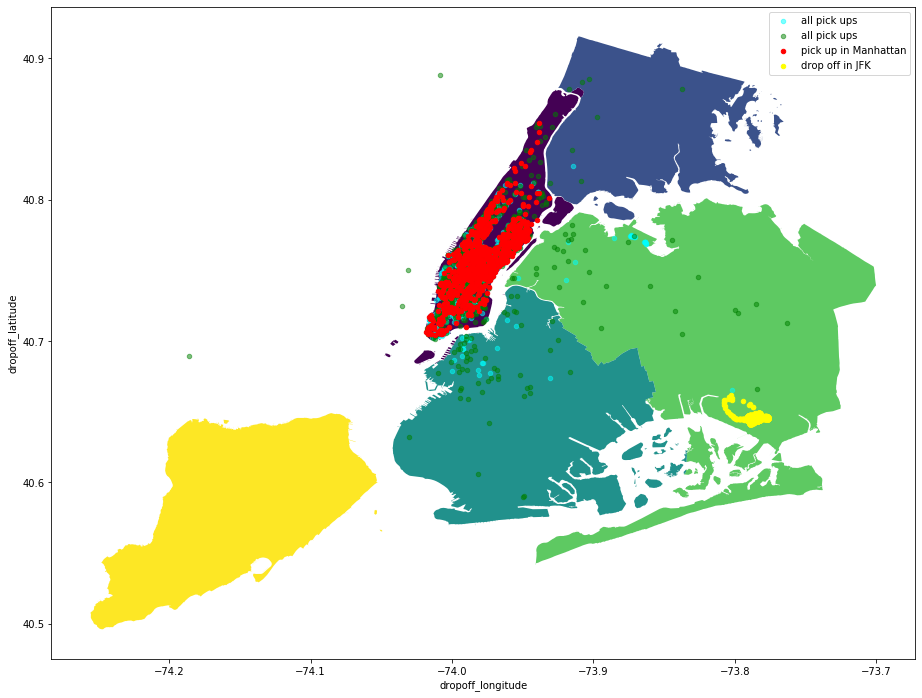

In [16]:
# much better...
fig, ax = plt.subplots(figsize=(16,12))

boros.plot(ax=ax, column='BoroCode', label="Boros")

original_data.plot.scatter(x="pickup_longitude", y="pickup_latitude", color='cyan', ax=ax, alpha=0.5, label="all pick ups")
original_data.plot.scatter(x="dropoff_longitude", y="dropoff_latitude", color='green', ax=ax, alpha=0.5, label="all pick ups")
filtered_data.plot.scatter(x='pickup_longitude', y='pickup_latitude', color='red', ax=ax, label="pick up in Manhattan")
filtered_data.plot.scatter(x='dropoff_longitude', y='dropoff_latitude', color='yellow', ax=ax, label="drop off in JFK")

# it looks mostly sane

In [0]:
# it took a bit longer, but the data looks sane.